<a href="https://colab.research.google.com/github/sarthakkaushik/Cdiscount-Image-Classification/blob/main/Cdiscount_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'

In [4]:
import os 
os.chdir(data_path)
print(os.getcwd())

/gdrive/MyDrive/UOH Assignment Dataset/cdiscount


In [5]:
# !pip install Pillow
import numpy as np
import pandas as pd
import io
import bson
import matplotlib.pyplot as plt
from imageio import imread
from tqdm import tqdm_notebook

In [6]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../cdiscount"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

categories.csv
category_names.csv
sample_submission.csv
test.bson
train.bson
train_example.bson
train_images.csv
train_offsets.csv
val_images.csv



In [7]:
data_dir = "../cdiscount/"

train_bson_path = os.path.join(data_dir, "category_names.csv")

In [8]:
categories = pd.read_csv(train_bson_path, index_col='category_id')

In [9]:
categories.head()

,category_level1,category_level2,category_level3
category_id,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [10]:
train_bson_path = os.path.join(data_dir, "train.bson")
test_bson_path = os.path.join(data_dir, "test.bson")


In [13]:
prod_id = []
prod_category = []
prod_num_imgs = []
prod_img=[]

num_dicts = 7069896 # according to data page

# This will take few minutes to complete
with open(train_bson_path, 'rb') as f, tqdm_notebook(total=num_dicts) as bar:
        
    data = bson.decode_file_iter(f)

    for c, d in enumerate(data):
        bar.update()
        prod_id.append(d['_id'])
        prod_category.append(d['category_id'])
        prod_num_imgs.append(len(d['imgs']))
        # prod_img.append(d['imgs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/7069896 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [13]:
#Create the dataframe
df_dict = {
    'category': prod_category,
    'num_imgs': prod_num_imgs
}
df = pd.DataFrame(df_dict, index=prod_id)
del df_dict # Free memory

In [14]:
df.head()

,category,num_imgs
0,1000010653,1
1,1000010653,1
2,1000004079,1
3,1000004141,1
4,1000015539,1


In [15]:
df.columns

Index(['category', 'num_imgs'], dtype='object')

1    4369441
2    1128588
4    1029075
3     542792
Name: num_imgs, dtype: int64

#Number of Image Per Category

In [31]:
df['num_imgs'].value_counts()

1    4369441
2    1128588
4    1029075
3     542792
Name: num_imgs, dtype: int64

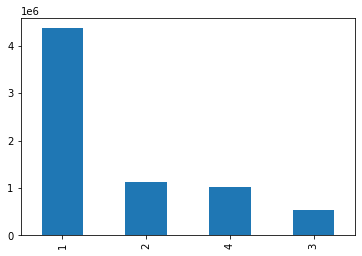

In [21]:
df.num_imgs.value_counts().plot(kind='bar');

# Let's see the top 10 most common category from the category table

In [37]:
df.category.value_counts().to_frame().head(10).join(categories)

,category,category_level1,category_level2,category_level3
1000018296,79640,MUSIQUE,CD,CD POP ROCK - CD ROCK INDE
1000011423,71116,INFORMATIQUE,IMPRESSION - SCANNER,TONER - RECUPERATEUR DE TONER
1000011427,69784,INFORMATIQUE,IMPRESSION - SCANNER,CARTOUCHE IMPRIMANTE
1000014202,65642,LIBRAIRIE,LITTERATURE,LITTERATURE FRANCAISE
1000015309,65435,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES
1000004085,61942,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,BATTERIE D'ALIMENTATION INFORMATIQUE
1000010653,61688,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
1000018290,60332,MUSIQUE,CD,CD MUSIQUE CLASSIQUE
1000018294,57748,MUSIQUE,CD,CD MUSIQUE DU MONDE
1000008094,56192,INFORMATIQUE,COMPOSANT - PIECE DETACHEE,DALLE D'ECRAN


# Let's see the top 10 least common category from the category table

In [38]:
df.category.value_counts().to_frame().tail(10).join(categories)

,category,category_level1,category_level2,category_level3
1000000896,12,EPICERIE,CONSERVE DE LEGUME,POIVRON EN CONSERVE
1000015609,12,CHAUSSURES - ACCESSOIRES,ACCESSOIRES CHAUSSURES,ESSUIE-BOTTES - LAVE-BOTTES
1000019484,12,MEUBLE,ACCESSOIRE DE MEUBLE,COLONNE SUSPENDUE
1000019804,12,SPORT,BASEBALL,BLOUSON DE BASEBALL - VESTE DE BASEBALL
1000007168,12,SPORT,CYCLES,TRIPORTEUR
1000022325,12,TV - VIDEO - SON,LECTEUR MUSIQUE,LECTEUR MP4 RECONDITIONNE - LECTEUR NUMERIQUE ...
1000015046,12,MATERIEL DE BUREAU,MATERIEL PEDAGOGIQUE,REGISTRE D'APPEL - CAHIER DE CLASSE
1000011955,12,MATERIEL MEDICAL,SOIN,CATHETER - OBTURATEUR
1000007760,12,PUERICULTURE,TOILETTE BEBE,EXTENSION DE ROBINET
1000010893,12,PHOTO - OPTIQUE,VISIONNAGE PHOTO,SCANNER DE DIAPOSITIVE


In [21]:
CHUNK_SIZE = 100000

def write_to_h5( lst ):
    df = pd.DataFrame(lst)
    try:
        df.iloc[:,:-1].to_hdf('file.h5',
                              key='train',
                              format='table',
                              append=True)
    except Exception as e:
        #catch disk full
        print('error: ',e)

with open('{}{}'.format(data_dir,'train.bson'),'rb',buffering=True) as b:
    i=0
    lst = []
    for line in bson.decode_file_iter(b):
        if i%CHUNK_SIZE == 0 and i !=0:
            write_to_h5( lst )
            lst=[]
        lst.append(line)
        i+=1
    write_to_h5( lst )

error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has no len()
error:  object of type 'int' has n

In [23]:
train = pd.read_hdf('file.h5',key='train')
#combine with categries
train = pd.merge(categories,train,right_on='category_id',left_index=True)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169896 entries, 31177 to 66217
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   category_level1  object
 1   category_level2  object
 2   category_level3  object
 3   _id              int64 
 4   category_id      int64 
dtypes: int64(2), object(3)
memory usage: 145.1+ MB


In [25]:
train.head()

,category_level1,category_level2,category_level3,_id,category_id
31177,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,13949623,1000021794
58678,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,14041540,1000021794
31768,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,16324224,1000021794
75721,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,18578863,1000021794
13502,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,19067770,1000021794


In [26]:
train.shape

(3169896, 5)

In [17]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [18]:
df.head()

,_id,imgs,category_id
0,0,[{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x0...,1000010653
1,1,[{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x0...,1000010653
2,2,[{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x0...,1000004079
3,3,[{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x0...,1000004141
4,4,[{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x0...,1000015539


In [19]:
df.shape

(100000, 3)

In [27]:
cats = train['category_level1'].value_counts()
cats.head()

AUTO - MOTO                 367260
INFORMATIQUE                286613
LIBRAIRIE                   282571
DECO - LINGE - LUMINAIRE    261209
TELEPHONIE - GPS            239102
Name: category_level1, dtype: int64

In [28]:
abbriv = cats.index.str.split('\W').str[0].str.strip()
abbriv

Index(['AUTO', 'INFORMATIQUE', 'LIBRAIRIE', 'DECO', 'TELEPHONIE', 'BRICOLAGE',
       'MUSIQUE', 'JEUX', 'BIJOUX', 'SPORT', 'ELECTROMENAGER', 'ART',
       'HYGIENE', 'TV', 'BAGAGERIE', 'MEUBLE', 'LOISIRS', 'PHOTO',
       'CHAUSSURES', 'JARDIN', 'ANIMALERIE', 'DVD', 'PUERICULTURE', 'JEUX',
       'TATOUAGE', 'ARTICLES', 'LITERIE', 'INSTRUMENTS', 'PARAPHARMACIE',
       'DROGUERIE', 'EPICERIE', 'MATERIEL', 'MERCERIE', 'ELECTRONIQUE', 'SONO',
       'TENUE', 'VIN', 'MATERIEL', 'BATEAU', 'CONDITIONNEMENT', 'POINT',
       'MANUTENTION', 'AMENAGEMENT', 'COFFRET', 'FUNERAIRE', 'PRODUITS',
       'ABONNEMENT', 'PRODUITS', 'APICULTURE'],
      dtype='object')

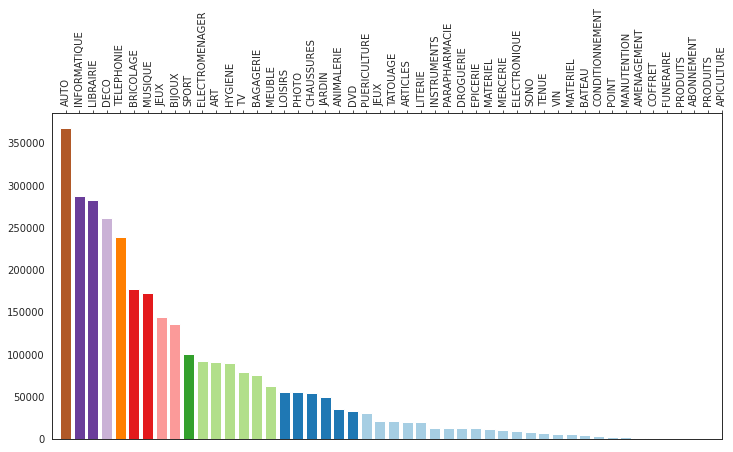

In [31]:
import seaborn as sns
import cv2 #opencv helpful for storing image as array

from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

sns.set_style('white')
fig,ax = plt.subplots(1,figsize=(12,6))
pal = ListedColormap(sns.color_palette('Paired').as_hex())
colors = pal(np.interp(cats,[cats.min(),cats.max()],[0,1]))
bars = ax.bar(range(1,len(cats)+1),cats,color=colors);
ax.set_xticks([]);
ax.set_xlim(0,len(cats))
ax1 = plt.twiny(ax)
ax1.set_xlim(0,len(cats))
ax1.set_xticks(range(1,len(abbriv)+1,1));
ax1.set_xticklabels(abbriv.values,rotation=90);
# sns.despine();